# Laplace Approximation for Coin Toss 

In [1]:
# import libraries
import jax
import jax.numpy as jnp
try:
  import distrax
except ModuleNotFoundError:
  %pip install -qq distrax
  import distrax
try:
  import optax
except ModuleNotFoundError:
  %pip install -qq optax
  import optax
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import logging
import pickle
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

2022-06-22 23:39:11.279882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Lets get the samples now.

In [3]:
with open("../data/coin_toss/coin_toss1",'rb') as f:
    data = pickle.load(f)

samples = data['data']
alpha = data['prior']['alpha']
beta = data['prior']['beta']
data

{'data': array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1], dtype=int32),
 'prior': {'alpha': 5, 'beta': 1}}

Lets see the histogram.

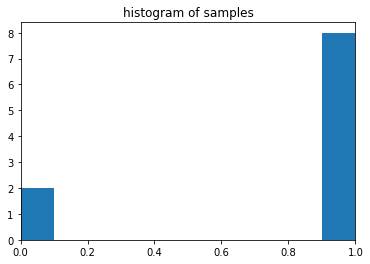

In [4]:
plt.hist(samples)
plt.xlim(0,1)
plt.title("histogram of samples")
plt.show()

In [5]:
beta_dist = tfd.Beta(alpha,beta)
@widgets.interact(alpha=(0,20,0.2),beta=(0,20,0.2))
def plot_beta(alpha=10,beta=15):
  beta_dist = tfd.Beta(alpha,beta)
  x = jnp.linspace(0,1,100)
  beta_pdf = beta_dist.prob(x)
  plt.plot(x,beta_pdf)
  plt.title('Prior PDF')
  plt.xlim(0,1)
#   plt.ylim(0,5)
  # plt.show()

interactive(children=(FloatSlider(value=10.0, description='alpha', max=20.0, step=0.2), FloatSlider(value=15.0…

In [6]:
# we give the logits here.
def log_postfn(x):
  # from the above equation
  # log_prior = -(x/lamda)**k+ (k-1)*(jnp.log(x)-jnp.log(lamda)) +jnp.log(k/lamda)
  prob = jax.nn.sigmoid(x)
  log_prior = beta_dist.log_prob(prob)

  # log_likelihood
  berno = tfd.Bernoulli(x)
  log_like =(jnp.sum(berno.log_prob(samples)))


  return -(log_like+log_prior)

log_postfn(0.02)


DeviceArray(7.995322, dtype=float32)

In [7]:
# we give probs here.
def log_postfn_without_trans(prob):
  log_prior = beta_dist.log_prob(prob)
  # log_likelihood
  berno = tfd.Bernoulli(probs=prob)
  log_like =(jnp.sum(berno.log_prob(samples)))
  return -(log_like+log_prior)

log_postfn_without_trans(jax.nn.sigmoid(0.02))


DeviceArray(7.995322, dtype=float32)

We need to maximize the numerator in the posteriror function in order to get the map estimate. So we use the automatic differencitation in jax to do this.



We know that 
\begin{align*}
    \mu &= argmax_\theta(log(posterior)) \\
    \sigma &= \sqrt{\frac{1}{H}}

\end{align*}
where $H$ is the hessian


In [8]:
# automatic differenciation for finding the mode of the posterior.

def fit(params,optimizer,steps):
  opt_state = optimizer.init(params)

  @jax.jit
  def step(params,opt_state):
    loss_value, grads = jax.value_and_grad(log_postfn)(params)
    updates, opt_state = optimizer.update(grads,opt_state,params)
    params = optax.apply_updates(params,updates)
    return params, opt_state, loss_value

  for i in range(steps):
    params,opt_state,loss_value = step(params, opt_state)
    if i % 100 == 0:
      print(f"step {i}, loss{loss_value}")
      pass
  return params

theta_init = 1.5
optimizer = optax.adam(learning_rate= 1e-2)
theta_MAP = fit(theta_init,optimizer,steps = 1000)
print(f"MAP found by automatic differenciation is {(jax.nn.sigmoid(theta_MAP))}")

step 0, loss4.210348606109619
step 100, loss4.1321940422058105
step 200, loss4.132190704345703
step 300, loss4.132191181182861
step 400, loss4.132191181182861
step 500, loss4.132191181182861
step 600, loss4.132191181182861
step 700, loss4.132190704345703
step 800, loss4.132190704345703
step 900, loss4.132190704345703
MAP found by automatic differenciation is 0.8571428656578064


In [9]:
# automatic differenciation for finding the mode of the posterior.

def fit(params,optimizer,steps):
  opt_state = optimizer.init(params)

  @jax.jit
  def step(carry,x):
    params = carry['params']
    opt_state = carry['opt_state']
    loss_value, grads = jax.value_and_grad(log_postfn)(params)
    updates, opt_state = optimizer.update(grads,opt_state,params)
    params = optax.apply_updates(params,updates)
    carry = {'params':params,'opt_state':opt_state}
    return carry, loss_value

  carry = {'params':params,'opt_state':opt_state}
  carry,loss = jax.lax.scan(step,carry,xs=None,length=steps)
  # for i in range(steps):
  #   params,opt_state,loss_value = step(params, opt_state)
  #   if i % 100 == 0:
  #     print(f"step {i}, loss{loss_value}")
  #     pass
  return carry,loss

theta_init = 1.5
optimizer = optax.adam(learning_rate= 1e-2)
carry,loss = fit(theta_init,optimizer,steps = 1000)
# print(loss)
print(carry)
theta_MAP = carry['params']
print(f"MAP found by automatic differenciation is {(jax.nn.sigmoid(theta_MAP))}")

{'opt_state': (ScaleByAdamState(count=DeviceArray(1000, dtype=int32), mu=DeviceArray(-7.111204e-24, dtype=float32, weak_type=True), nu=DeviceArray(0.00117429, dtype=float32, weak_type=True)), EmptyState()), 'params': DeviceArray(1.7917595, dtype=float32)}
MAP found by automatic differenciation is 0.8571428656578064


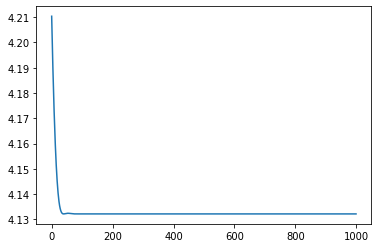

In [10]:
plt.plot(loss)

In [11]:
from jax import grad
print(theta_MAP)

def mult(x):
    a = grad(log_postfn)(x)
    b = grad(jax.scipy.special.logit)(x)
    return a*b


hessian = grad(mult)(theta_MAP)
print(hessian)

1.7917595
-1.2083986


In [12]:
hessian_without_tras = grad(grad(log_postfn_without_trans))(jax.nn.sigmoid(theta_MAP))
hessian_without_tras

DeviceArray(114.333336, dtype=float32)

Now we have to find the value of the hessian (here just the scalar). value of $\frac{1}{\sigma^2}$

In [13]:
jnp.sum(samples==1)
one= jnp.sum(samples==1).astype('float32')
zero= jnp.sum(samples==0).astype('float32')
print(one,zero)
import seaborn as sns

8.0 2.0


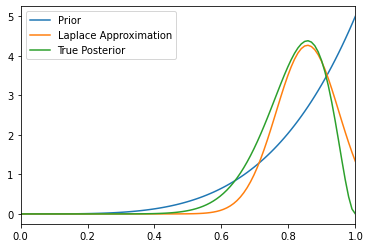

In [14]:

# plt.hist(jax.nn.sigmoid(states.position[300:,0]),density=True,bins=20)

x = jnp.linspace(0,1,100)

#prior
beta_pdf = beta_dist.prob(x)
plt.plot(x,beta_pdf,label="Prior")

# estimated posterior
normal = tfd.Normal(loc=jax.nn.sigmoid(theta_MAP),scale=jnp.sqrt((1/(hessian_without_tras))))

with open("../results/coin_toss/results_data/coin_toss_laplace_result1",'wb') as f:
    pickle.dump(normal,f,protocol=1)

normal_pdf = normal.prob(x)
plt.plot(x,normal_pdf,label="Laplace Approximation")

# true posterior
beta_dist_post = tfd.Beta(alpha+one,beta+zero)
post_pdf = beta_dist_post.prob(x)
plt.plot(x,post_pdf,label="True Posterior")
plt.legend()
plt.xlim(0,1)
plt.show()

Now lets see how well the samples are fitting our initial data.

I will just compare with the actual pdf.

<h1> So I am happy :)</h1>